In [157]:
from __future__ import print_function
from utils import init_env
init_env('0')
from config import config as cfg
from models import dense121_unet
import os
import glob
import numpy as np
from dataset.data import rle_encode
from skimage import morphology as m
from skimage.io import imread
from matplotlib import pyplot as plt
from keras import backend as K
%matplotlib inline
import cv2
from skimage import  measure

In [2]:
def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = m.label(img[0, :, :, :], connectivity=2)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

In [62]:
K.clear_session()
model = dense121_unet(cfg.input_shape)

In [221]:
cfg.task_name = 'dense_unet'
epoch = 23
log_dir = os.path.join(cfg.log_dir, cfg.task_name)
weights_path = os.path.join(log_dir, cfg.weigts_file.format(epoch=epoch))
model.load_weights(weights_path)

In [6]:
test_img_paths = glob.glob(os.path.join(cfg.test_dir, '*.jpg'))

In [222]:
def model_predict(model, test_img, tta=True):
    if tta:
        pred_prob1 = model.predict(test_img)
        
        pred_prob2 = model.predict(np.flip(test_img, axis=1))
        
        pred_prob2 = np.flip(pred_prob2, axis=1)
        
        pred_prob3 = model.predict(np.flip(test_img, axis=2))
        pred_prob3 = np.flip(pred_prob3, axis=2)
        
        test_img4 = np.flip(test_img, axis=1)
        test_img4 = np.flip(test_img4, axis=2)
        pred_prob4 = model.predict(test_img4)
        pred_prob4 = np.flip(pred_prob4, axis=2)
        pred_prob4 = np.flip(pred_prob4, axis=1)
        pred_prob = (pred_prob1 + pred_prob2 + pred_prob3 + pred_prob4) / 4
    else:
        pred_prob = model.predict(test_img)
    return pred_prob

V:\data_repos/airbus_ship_detection\test_v2\00e5fb033.jpg


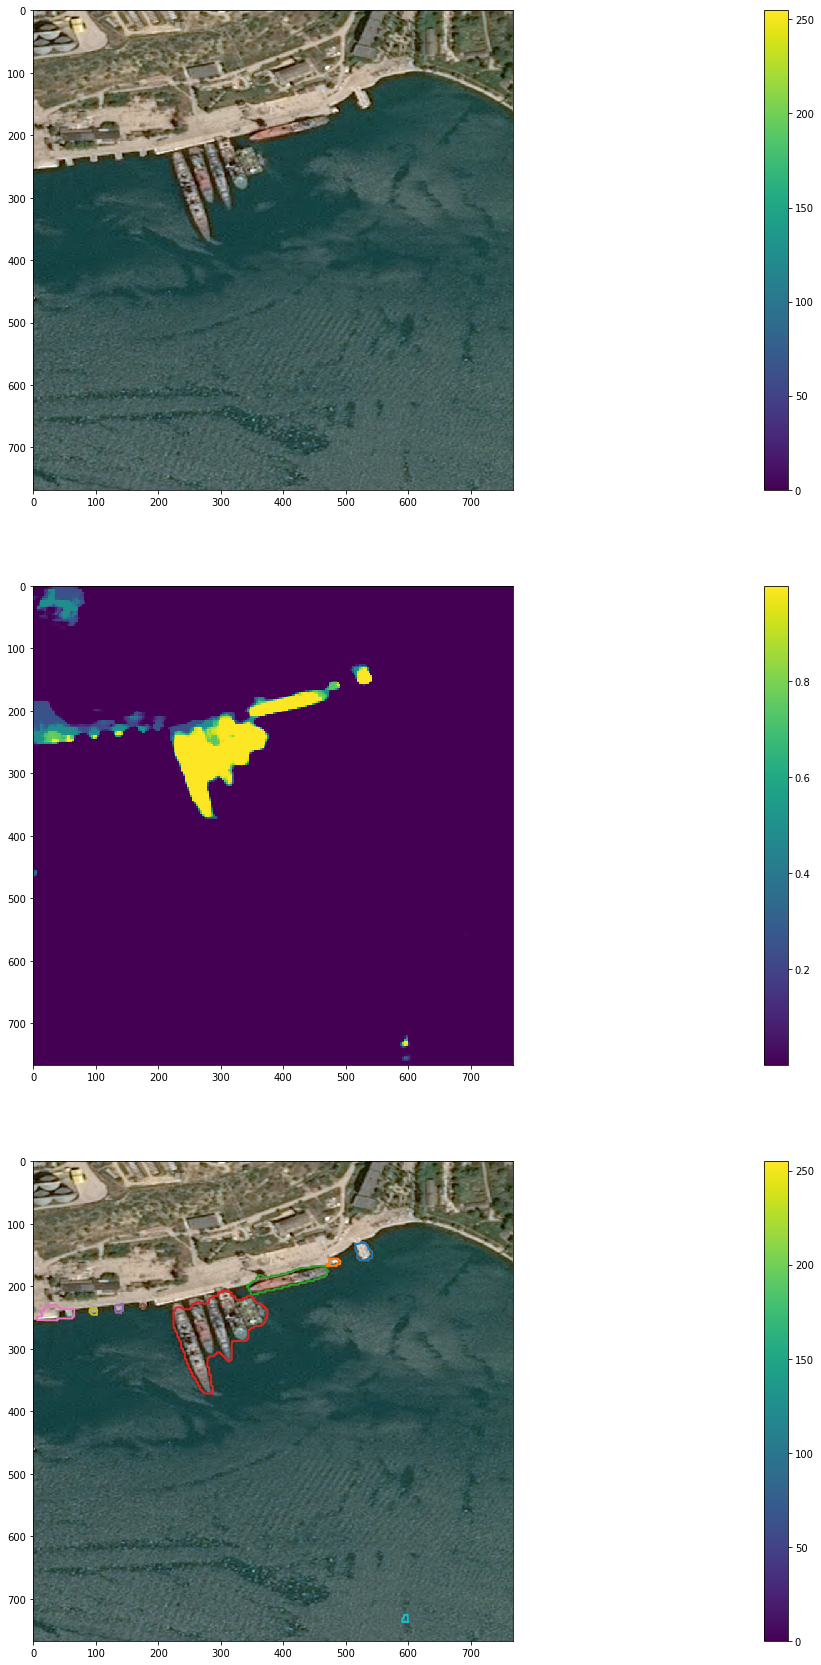

In [223]:
path = test_img_paths[66]
print(path)
test_img = imread(path)
batch_img = test_img.reshape(1, 768, 768, 3) / 255.0
# pred_prob = model_predict(model, batch_img)
pred_prob = model_predict(model, batch_img, tta=True)
pred = np.squeeze(pred_prob)
plt.figure(figsize=(90, 30))
plt.subplot(311)
plt.imshow(test_img)
plt.colorbar()
plt.subplot(312)
plt.imshow(pred)
plt.colorbar()
plt.subplot(313)
threshod = 0.5
plt.imshow(test_img)
contours = measure.find_contours(pred, threshod)
for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
plt.colorbar()

In [188]:
measure.find_contours?